# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

# Methodology
* In this notebook, I'll demonstrate how to create dataset from **run_length_encode** mask. 
* As it takes quite some to convert **rle** masks to **seantic** masks on-fly, we'll pre-computed the **semantic** masks and save them to avoid **bottleneck** during training.
* I"ll also be using **Weights & Biases** for interactive visualization.

# Notebooks
📌 **2.5D-TransUnet**:
* Train: [UWMGI: TransUNet 2.5D [Train] [TF]](https://www.kaggle.com/code/awsaf49/uwmgi-transunet-2-5d-train-tf)

📌 **2.5D**:
* Train: [UWMGI: 2.5D [Train] [PyTorch]](https://www.kaggle.com/awsaf49/uwmgi-2-5d-train-pytorch/)
* Infer: [UWMGI: 2.5D [Infer] [PyTorch]](https://www.kaggle.com/awsaf49/uwmgi-2-5d-infer-pytorch/)
* Data: [UWMGI: 2.5D stride=2 Data](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-stride-2-data/)
* Dataset: [UWMGI: 2.5D stride=2 Dataset](https://www.kaggle.com/datasets/awsaf49/uwmgi-25d-stride2-dataset)

📌 **UNet**:
* Train: [UWMGI: Unet [Train] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/)
* Infer: [UWMGI: Unet [Infer] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-infer-pytorch/)

📌 **MMDetection**:
* Train: [UWMGI: MMDetection [Train]](https://www.kaggle.com/code/awsaf49/uwmgi-mmdetection-train)

📌 **Data/Dataset**:
* Data: [UWMGI: Mask Data](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-data)
* Dataset: [UWMGI: Mask Dataset](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-dataset)

# Install Libraries

In [4]:
# !pip install wandb --upgrade

# Import Libraries

In [5]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# import tensorflow as tf

# WandB

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

How to find `WANDB_API_KEY`?
1. Login to [wandb.ai](https://wandb.ai/login).
2. Goto your [Settings](https://app.wandb.ai/settings) Page.
3. Scroll down and select `NEW_KEY`  in `API keys` tab.

In [6]:
import wandb
wandb.login()

# try:
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     api_key = user_secrets.get_secret("WANDB")
#     wandb.login(key=api_key)
# except:
#     wandb.login(anonymous='must',relogin=True)
#     print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cwinsor. Use `wandb login --relogin` to force relogin


True

# Configs

In [7]:
NUM_LOG = 1000 # for WandB interactive Visualiztion
NO_EMPTY = True # set False to include images with empty mask in WandB

# Utilities

## RLE

In [8]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


## Metadata

In [9]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

## Mask

In [10]:
def id2mask(id_, df=None):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

## Image

In [11]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

# Meta Data

## Train

In [12]:
# from tqdm import tqdm

In [13]:
# df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
df = pd.read_csv('/mnt/d/code_medimg_practice/data/train.csv')
# df = df.progress_apply(get_metadata, axis=1)
df = df.apply(get_metadata, axis=1)
df.head()

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1
2,case123_day20_slice_0001,stomach,NaN,123,20,1
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2


## Path

In [14]:
# paths = glob('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/*/*/*/*')
paths = glob('/mnt/d/code_medimg_practice/data/train/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])
# path_df = path_df.progress_apply(path2info, axis=1)
path_df = path_df.apply(path2info, axis=1)
df = df.merge(path_df, on=['case','day','slice'])
df.head()

,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/mnt/d/code_medimg_practice/data/train/case123...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/mnt/d/code_medimg_practice/data/train/case123...,266,266


# Check Mask

/tmp/ipykernel_1863/3882440873.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_1863/3882440873.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_1863/3882440873.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


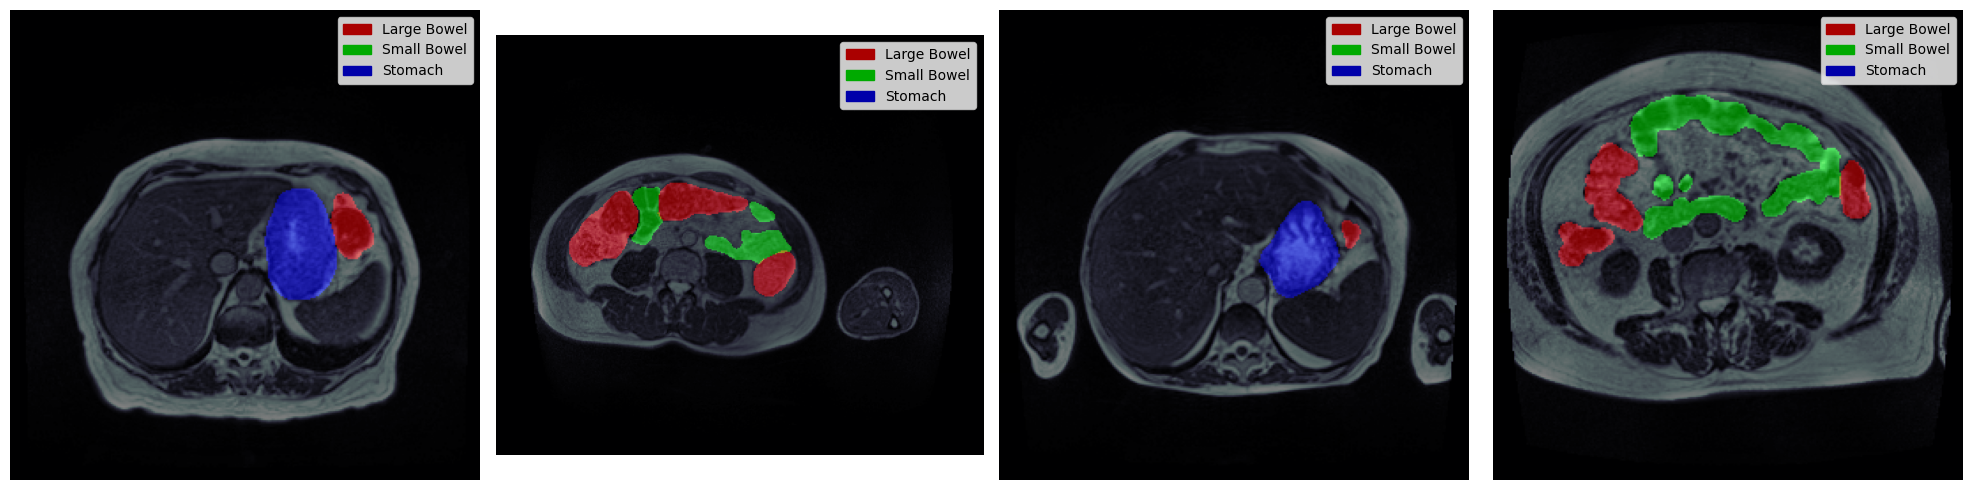

In [15]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[:row*col]):
    img = load_img(df[df['id']==id_].image_path.iloc[0])
    mask = id2mask(id_,df=df)*255
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

# Initiate **Wandb** Project

In [16]:
# Initialize WANDB project
run = wandb.init(project='uwmgi-mask-data', 
                 config={},
#                  anonymous=anonymous,
                 name=f"mask-data-noresize-v2",
                )
# Columns for wandb table
columns=["id", "case", "day", "slice", "empty", "image"]
# Initialize table
table = wandb.Table(columns=columns)
# Labels for mask
class_labels = {
#     0:"Background",
    1:"Large Bowel",
    2:"Small Bowel",
    3:"Stomach",
}

# Write Mask

In [17]:
def save_mask(id_,df=None, count=0):
    # print(count)
    # print(df.head())
    # assert False, "hold up"
    
    idf = df[df['id']==id_]
    mask = id2mask(id_, df=df) # mask from [0, 1] to [0, 255]
    image_path = idf.image_path.iloc[0]
    img = load_img(image_path) # load image
    # mask_path = image_path.replace('/kaggle/input/','/tmp/png/')
    mask_path = image_path.replace('/mnt/d/code_medimg_practice/data/train/','/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_01/tmp/png/')

    mask_folder = mask_path.rsplit('/',1)[0]
    os.makedirs(mask_folder, exist_ok=True)
    cv2.imwrite(mask_path, mask*255, [cv2.IMWRITE_PNG_COMPRESSION, 1]) # write mask as .png
    # mask_path2 = image_path.replace('/kaggle/input/','/tmp/np/').replace('.png','.npy')
    mask_path2 = image_path.replace('/mnt/d/code_medimg_practice/data/train/','/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_01/tmp/np/').replace('.png','.npy')
    
    mask_folder2 = mask_path2.rsplit('/',1)[0]
    os.makedirs(mask_folder2, exist_ok=True)
    np.save(mask_path2, mask*255) # write mask as .npy
    # log each image in WandB table
    if count<=NUM_LOG:
        img = cv2.resize(img, dsize=(160, 192), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, dsize=(160, 192), interpolation=cv2.INTER_NEAREST)
        table.add_data(id_, 
                       idf.case.iloc[0], 
                       idf.day.iloc[0],
                       idf.slice.iloc[0],
                       int(mask.sum()==0),
                       wandb.Image(img, masks={
    #         "predictions" : {
    #             "mask_data" : prediction,
    #             "class_labels" : class_labels
    #         },
            "ground_truth" : {
                "mask_data" : rgb2gray(mask), # (height, width, 3) => (height, width) => may lose overlap data
                "class_labels" : class_labels
            }}))
    return mask_path

In [18]:
tmp_df = df.copy()
print(f"NO_EMPTY={NO_EMPTY}")
if NO_EMPTY:
    tmp_df = tmp_df[~df.segmentation.isna()]
ids = tmp_df['id'].unique()
# Save Mask
# _ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
#                                              for i, id_ in enumerate(tqdm(ids, total=len(ids))))
# for i, id_ in enumerate(ids):
#     save_mask(id_, df=tmp_df, count=i)
# _ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
#                                             for i, id_ in enumerate(tqdm(ids)))
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
                                            for i, id_ in enumerate(ids))

NO_EMPTY=True


# Log & Display **WandB** Table

In [19]:
# Log table to WandB
wandb.log({"Table":table})
# Finish The Run
wandb.finish()
# Display the Run
display(ipd.IFrame(run.url, width=1000, height=720))

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


# Access **WandB** tables

wandb:   2004 of 2004 files downloaded.  


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


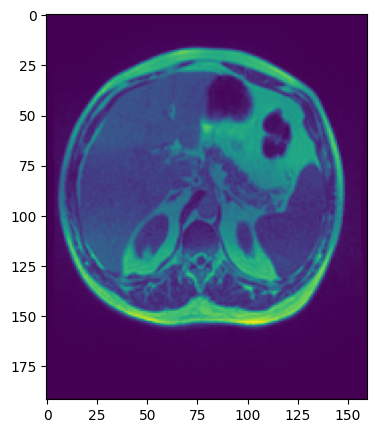

In [20]:
with wandb.init(project='uwmgi-mask-data') as run2:
    table2= run2.use_artifact(f"run-{run.id}-Table:v0").get("Table")
    
for idx, row in table2.iterrows():
    break
plt.figure(figsize=(5,5))
plt.imshow(np.array(row[-1].image))
# plt.imshow(row[1]._masks["ground_truth"]._val["mask_data"].astype('uint8')*255)

# Check Saved Mask

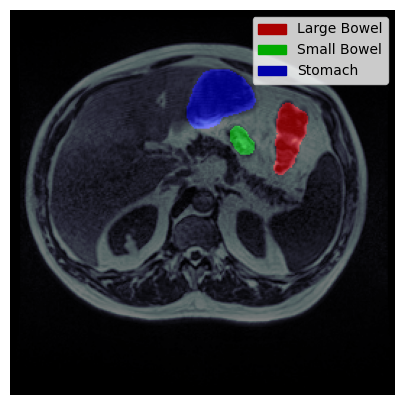

In [21]:
i = 250
img = load_img(df.image_path.iloc[i])
# mask_path = df['image_path'].iloc[i].replace('/kaggle/input/','/tmp/png/')
mask_path = df['image_path'].iloc[i].replace('/mnt/d/code_medimg_practice/data/train/','/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_01/tmp/png/')

mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(5,5))
show_img(img, mask=mask)

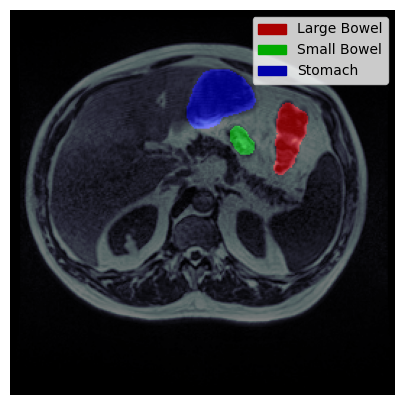

In [22]:
i = 250
img = load_img(df.image_path.iloc[i])
# mask_path = df['image_path'].iloc[i].replace('/kaggle/input/','/tmp/np/').replace('.png','.npy')
mask_path = df['image_path'].iloc[i].replace('/mnt/d/code_medimg_practice/data/train/','/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_01/tmp/np/').replace('.png','.npy')
mask = np.load(mask_path)
plt.figure(figsize=(5,5))
show_img(img, mask=mask)

# Save Metadata

In [23]:
# df['mask_path'] = df.image_path.str.replace('/kaggle/input','/kaggle/input/uwmgi-mask-dataset/png/')
df['mask_path'] = df.image_path.str.replace('/mnt/d/code_medimg_practice/data/train/','/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_01/tmp/png/')
df.to_csv('/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_01/train.csv',index=False)

# Compress Files

In [24]:
# shutil.make_archive('/kaggle/working/png',
#                     'zip',
#                     '/tmp/png',
#                     'uw-madison-gi-tract-image-segmentation')
archive_name = os.path.join('/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_02', 'png')
root_dir     = os.path.join('/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_01/tmp', 'png')
shutil.make_archive(archive_name, 'zip', root_dir)
# make_archive('/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_02/png'
#                     'zip',
#                     '/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_01/tmp/png',
#                     'foo')

'/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_02/png.zip'

In [25]:
archive_name = os.path.join('/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_02', 'np')
root_dir     = os.path.join('/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_01/tmp', 'np')
shutil.make_archive(archive_name, 'zip', root_dir)

'/mnt/d/code_medimg_practice/medical_image_practice/04b_2pt5d/data_02/np.zip'

In [26]:
'done'

'done'